In [1]:
import re    
import molgrid    
import numpy as np    
import torch    
import torch.nn as nn    
import torch.nn.functional as F    
import torch.optim as optim    
from torch.nn import init    
from torch import autograd    
import wandb    
import argparse    
from scipy.stats import pearsonr    
import matplotlib.pyplot as plt    
import matplotlib as mpl
from glob import glob
from argparse import Namespace
from python_files.models.multtask_latent_dense_model import Dense as DenseNet
from python_files.models.multtask_latent_def2018_model import Net

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
batch_size=2
dropout = 0
# Using test because it is a smaller set
ligtr = 'cache/lig_full_bdb.molcache2'
rectr = 'cache/rec_full_bdb.molcache2'
trainfile='new_Prot_Lig_Valid/all_newdata.types'
args = Namespace(dropout=0,hidden_size=0)

In [4]:
train_samples = molgrid.ExampleProvider(ligmolcache=ligtr,recmolcache=rectr,
                                        shuffle=False, duplicate_first=True,
                                        default_batch_size=batch_size,iteration_scheme=molgrid.IterationScheme.SmallEpoch)
train_samples.populate(trainfile)

In [5]:
gmaker = molgrid.GridMaker()
dims = gmaker.grid_dimensions(14*4)
tensor_shape = (batch_size,) + dims
actual_dims = (dims[0]//2, *dims[1:])
# model = Net(actual_dims,dropout)
print(actual_dims,dims)

(28, 48, 48, 48) (56, 48, 48, 48)


In [6]:
input_tensor_1 = torch.zeros(dims, dtype=torch.float32)
input_tensor_2 =  torch.zeros(tensor_shape, dtype=torch.float32)
dg1_labels = torch.zeros(batch_size,dtype=torch.float32)

In [7]:
model = Net(actual_dims,args)
pretrained_state_dict = torch.load("models/full_train/def2018/model_0_def2018.h5")
model_dict = model.state_dict()
# pretrained_state_dict['fc.weight'] = pretrained_state_dict.pop('affinity_output.weight')
# pretrained_state_dict['fc.bias'] = pretrained_state_dict.pop('affinity_output.bias')
pretrained_dict = {k: v for k, v in pretrained_state_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

27648


<All keys matched successfully>

In [8]:
densemodel = DenseNet(actual_dims,args)
pretrained_state_dict = torch.load("models/full_train/dense/model_0_dense.h5")
model_dict = densemodel.state_dict()
# pretrained_state_dict['fc.weight'] = pretrained_state_dict.pop('affinity_output.weight')
# pretrained_state_dict['fc.bias'] = pretrained_state_dict.pop('affinity_output.bias')
pretrained_dict = {k: v for k, v in pretrained_state_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
densemodel.load_state_dict(model_dict)

<All keys matched successfully>

In [12]:
ex = train_samples.next()
ddg_label = torch.tensor(ex.labels[1])
lig1_label = torch.tensor(ex.labels[2])
lig2_label = torch.tensor(ex.labels[3])
center = ex.coord_sets[-1].center()
# batch = train_samples.next_batch()
# batch.extract_label(0,dg1_labels)
# lig1_labels = dg1_labels

In [20]:
def eval_translational_inv(model,direction=(1,1,0)):
    loss_dict = dict()
    t1 = molgrid.Transform()
    t1.set_rotation_center(center)
    last_input=None
    for val in np.linspace(0,2,num=200):
        t1.set_translation(tuple([d*val for d in direction]))
        gmaker.forward(ex, t1, input_tensor_1)
        # if last_input is not None:
        #     print(torch.eq(input_tensor_1,last_input).all())
        # gmaker.forward(batch, input_tensor_2)
        # fr_complex = input_tensor_1.unsqueeze(0)
        pred_ddg, pred_dg1, pred_dg2, _, _  = model(input_tensor_1.unsqueeze(0)[:,:28,:,:,:],input_tensor_1.unsqueeze(0)[:,28:,:,:,:])
        sq_e_ddg = nn.functional.mse_loss(pred_ddg[0].squeeze(),ddg_label,reduction='none')
        sq_e_dg1 = nn.functional.mse_loss(pred_dg1[0].squeeze(),lig1_label,reduction='none')
        sq_e_dg2 = nn.functional.mse_loss(pred_dg2[0].squeeze(),lig2_label,reduction='none')
        loss_dict[val] = [sq_e_ddg.item(),sq_e_dg1.item(),sq_e_dg2.item()]
        last_input = input_tensor_1.detach().clone()

    plt.plot(loss_dict.keys(),[val[0] for val in loss_dict.values()], label='ddg')
    plt.plot(loss_dict.keys(),[val[1] for val in loss_dict.values()], label='dg1')
    plt.plot(loss_dict.keys(),[val[2] for val in loss_dict.values()], label='dg2')
    plt.xlabel('translation along x')
    plt.ylabel('Squared Error')
    plt.legend()
    plt.title(f"Translate:{direction}")

# Default2018 Model

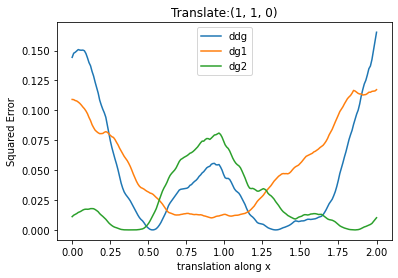

In [24]:
eval_translational_inv(model,(1,1,0))

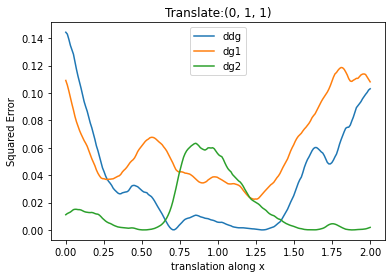

In [22]:
eval_translational_inv(model,(0,1,1))

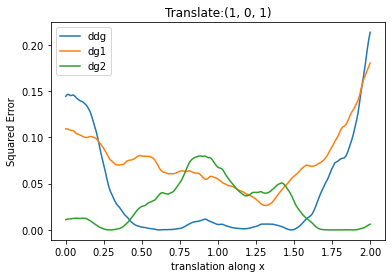

In [25]:
eval_translational_inv(model,(1,0,1))

# Dense Model

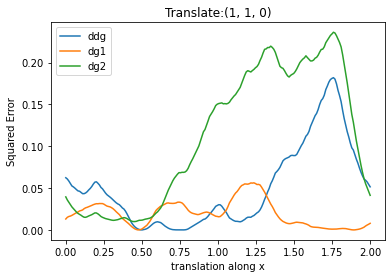

In [27]:
eval_translational_inv(densemodel,(1,1,0))

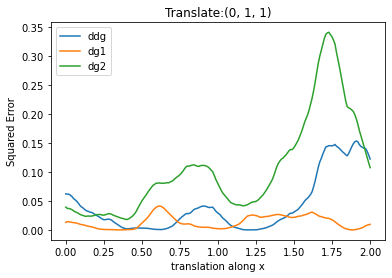

In [21]:
eval_translational_inv(densemodel,(0,1,1))

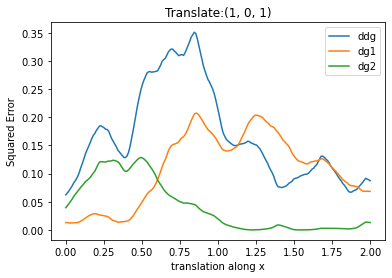

In [28]:
eval_translational_inv(densemodel,(1,0,1))

In [79]:
def eval_trans_inv_noedge(model,direction=(1,1,0)):
    plt.figure(figsize=(10,8))

    loss_dict = dict()
    t1 = molgrid.Transform()
    t1.set_rotation_center(center)
    gmaker.forward(ex, t1, input_tensor_1)
    pred_ddg, pred_dg1, pred_dg2, _, _  = model(input_tensor_1.unsqueeze(0)[:,:28,:,:,:],input_tensor_1.unsqueeze(0)[:,28:,:,:,:])
    sq_e_ddg = nn.functional.mse_loss(pred_ddg[0].squeeze(),ddg_label,reduction='none')
    sq_e_dg1 = nn.functional.mse_loss(pred_dg1[0].squeeze(),lig1_label,reduction='none')
    sq_e_dg2 = nn.functional.mse_loss(pred_dg2[0].squeeze(),lig2_label,reduction='none')
    plt.axhline(sq_e_ddg,label='ddg full',ls='--',c='b')
    plt.axhline(sq_e_dg1,label='dg1 full',ls='--',c='orange')
    plt.axhline(sq_e_dg2,label='dg2 full',ls='--',c='g')
    inside_input_tensor = input_tensor_1[:,6:-6,6:-6,6:-6]
    # print(inside_input_tensor.shape,input_tensor_1.shape)
    last_input=None
    left_pad,right_pad = 0,12
    center_pad = 6
    while right_pad >= 0:
        # print(tuple([pad if d else 0 for d in direction for pad in [left_pad,right_pad]]))
        padded_input_tensor = nn.functional.pad(inside_input_tensor.unsqueeze(0),
                tuple([pad if d else center_pad for d in direction for pad in [left_pad,right_pad]]),
                value=0,mode='constant')
        pred_ddg, pred_dg1, pred_dg2, _, _  = model(padded_input_tensor[:,:28,:,:,:],padded_input_tensor[:,28:,:,:,:])
        sq_e_ddg = nn.functional.mse_loss(pred_ddg[0].squeeze(),ddg_label,reduction='none')
        sq_e_dg1 = nn.functional.mse_loss(pred_dg1[0].squeeze(),lig1_label,reduction='none')
        sq_e_dg2 = nn.functional.mse_loss(pred_dg2[0].squeeze(),lig2_label,reduction='none')
        loss_dict[left_pad] = [sq_e_ddg.item(),sq_e_dg1.item(),sq_e_dg2.item()]
        left_pad += 1
        right_pad -= 1

    plt.plot(loss_dict.keys(),[val[0] for val in loss_dict.values()], label='ddg',c='b')
    plt.plot(loss_dict.keys(),[val[1] for val in loss_dict.values()], label='dg1',c='orange')
    plt.plot(loss_dict.keys(),[val[2] for val in loss_dict.values()], label='dg2',c='g')
    plt.xlabel('Magnitude of Translation')
    plt.ylabel('Squared Error')
    plt.legend()
    plt.title(f"Translate:{direction}")

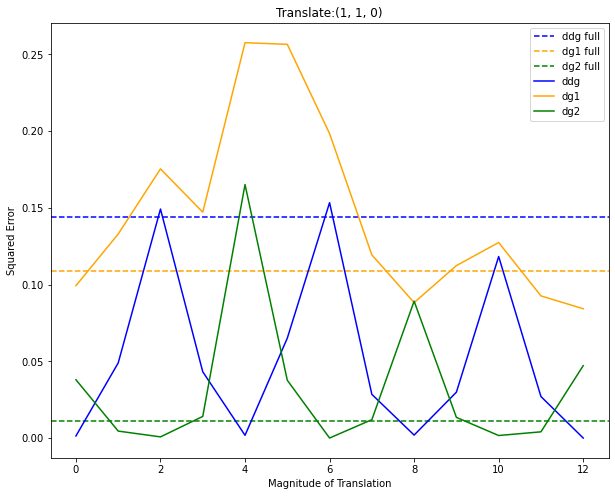

In [80]:
eval_trans_inv_noedge(model)

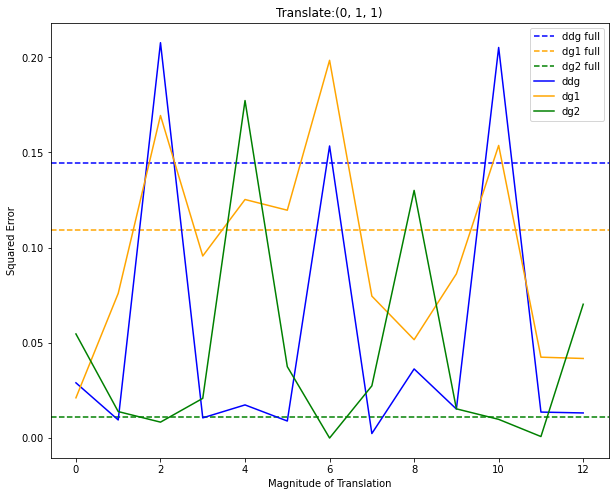

In [81]:
eval_trans_inv_noedge(model,(0,1,1))

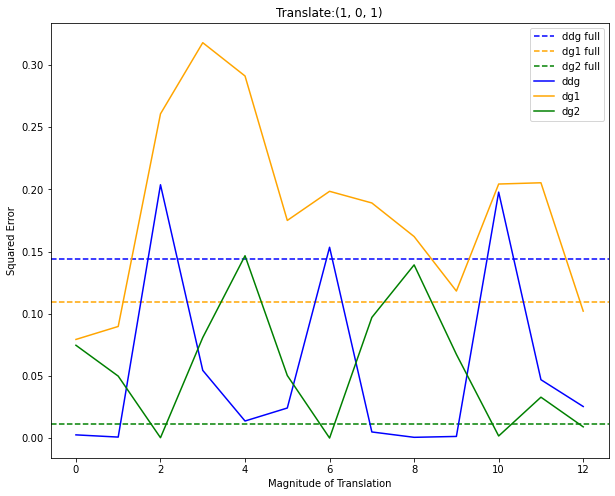

In [82]:
eval_trans_inv_noedge(model,(1,0,1))

# Dense Model

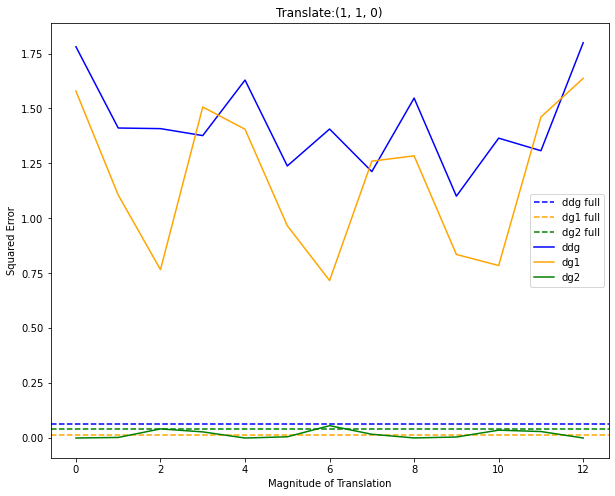

In [83]:
eval_trans_inv_noedge(densemodel)

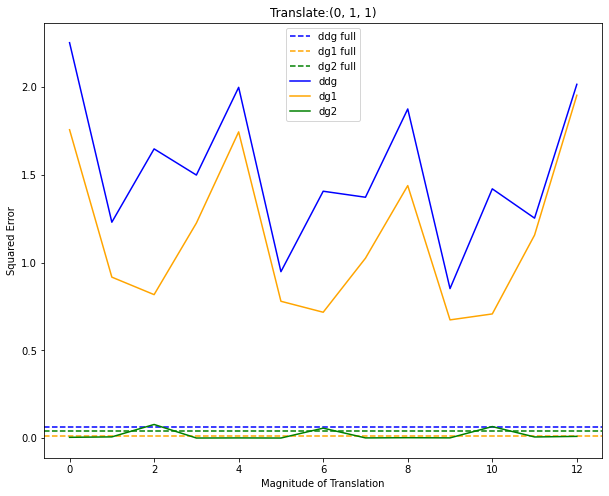

In [84]:
eval_trans_inv_noedge(densemodel,(0,1,1))

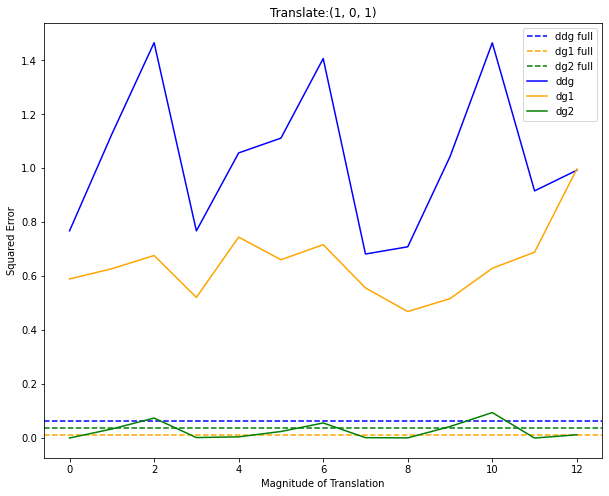

In [85]:
eval_trans_inv_noedge(densemodel,(1,0,1))